# **XÂY DỰNG MÔ HÌNH HỌC MÁY MACHINE LEARNING ĐỂ DỰ ĐOÁN GIÁ NHÀ Ở THÀNH PHỐ BẮC KINH**

**Tổng quan dự án:**

* Khai báo thư viện
* Xử lý dữ liệu
* Chọn thuật toán và đánh giá
* Xây dựng mô hình dự đoán
* Xây dựng mô hình thuật toán mới, cải thiện kết quả dự đoán

# **KHAI BÁO THƯ VIỆN, ĐỌC DỮ LIỆU**

In [ ]:
!pip install lightgbm
!pip install xgboost
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# BỎ QUA CẢNH BÁO TRONG TƯƠNG LAI
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# KHAI BÁO THƯ VIỆN BIỂU ĐỒ
import seaborn as sns
import matplotlib.pyplot as plt

# KIỂM ĐỊNH THỐNG KÊ
from scipy import stats

# CHUYỂN ĐỔI DỮ LIỆU DANH MỤC SANG DẠNG SỐ
from sklearn.preprocessing import LabelEncoder

# KHAI BÁO CÁC MÔ HÌNH, CHỈ SỐ ĐÁNH GIÁ
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import early_stopping

# ĐỌC DỮ LIỆU
df =  pd.read_csv('new.csv',encoding='gbk',low_memory=False)

# SHOW DỮ LIỆU MẪU
print ('DATA',df.shape)
df.head()


DATA (318851, 26)


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,131.00,2,1,1,1,高 26,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,132.38,2,2,1,2,高 22,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,198.00,3,2,1,3,中 4,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,134.00,3,1,1,1,底 21,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,81.00,2,1,1,1,中 6,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


# **XỬ LÝ DỮ LIỆU**

# **LỌC DỮ LIỆU**

In [ ]:
# TÌM CÁC DỮ LIỆU BỊ THIẾU
df.isnull().sum()

,0
url,0
id,0
Lng,0
Lat,0
Cid,0
tradeTime,0
DOM,157977
followers,0
totalPrice,0
price,0


In [ ]:
# XÓA CÁC CỘT CÓ DỮ LIỆU THIẾU HƠN 50% VÀ CÁC CỘT KHÔNG CẦN THIẾT
df.drop(['DOM','url','kitchen','drawingRoom','bathRoom','Cid','id','totalPrice'],axis=1,inplace=True)

# XÓA CÁC HÀNG TRỐNG
df.dropna(inplace=True)
df = df[df['constructionTime']!='未知']

# XUẤT RA DỮ LIỆU CÒN LẠI SAU KHI ĐÃ XỬ LÝ
print ("DATA", df.shape)

DATA (297701, 18)


# **FEATURE ENGINEERING**

In [ ]:
#TẠO CỘT DISTANCE
from math import radians, cos, sin, asin, sqrt

def distance(lat2, lon2, lat1=39.916668, lon1=116.383331):
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    r = 6371  # Bán kính trái đất (km)
    return(c * r)

df['distance'] = df.apply(lambda x: distance(x['Lat'], x['Lng']), axis=1)

#TẠO CỘT "AGE"
df['constructionTime'] = df['constructionTime'].astype(int)
df['Age'] = 2019 - df['constructionTime']

#CHUYỂN ĐỔI TRADETIME VỀ DẠNG NĂM
df['tradeTime'] = pd.DatetimeIndex(df['tradeTime']).year

#TẠO FLOOR TYPE VÀ FLOOR HEIGH
lst_numeric = []
lst_str = []
for value in df['floor'].values:
    value = value.split()
    numeric = (value[1])
    string  = value[0]
    lst_numeric.append(numeric)
    lst_str.append(string)

# Thay thế từ tiếng Trung bằng tiếng Anh
lst_str_eng = []
for string in lst_str:
    if string == '中':
        lst_str_eng.append(string.replace('中', 'middle'))
    elif string == '高':
        lst_str_eng.append(string.replace('高', 'high'))
    elif string == '底':
        lst_str_eng.append(string.replace('底', 'bottom'))
    elif string == '低':
        lst_str_eng.append(string.replace('低', 'low'))
    elif string == '未知':
        lst_str_eng.append(string.replace('未知', 'unknown'))
    elif string == '顶':
        lst_str_eng.append(string.replace('顶', 'top'))

df1 = pd.DataFrame(lst_str_eng, columns=['floorType'])
df2 = pd.DataFrame(lst_numeric, columns=['floorHeight'])
df = pd.concat([df, df1, df2], axis=1)

# Xóa các giá trị không xác định
df = df[df['floorType'] != 'unknown']

# XÓA CÁC HÀNG MISSING VALUE
df.dropna(inplace=True)

# XÓA CÁC CỘT KHÔNG CẦN THIẾT NHƯ FLOOR VÀ CONSTRUCTIME SAU KHI ĐÃ XỬ LÝ

df.drop(['floor', 'constructionTime'], axis=1, inplace=True)

#THAY THẾ CÁC GIÁ TRỊ SỐ TRONG CỘT BUILDINGTYPE THÀNH DẠNG NHÀ BẰNG TIẾNG ANH
df['buildingType'].replace(1, 'Tower', inplace=True)
df['buildingType'].replace(2, 'Bungalow', inplace=True)
df['buildingType'].replace(3, 'Tower and Plate', inplace=True)
df['buildingType'].replace(4, 'Plate', inplace=True)

#CHUYỂN ĐỔI DỮ LIỆU VỀ DẠNG SỐ NGUYÊN ĐỂ DỄ XỬ LÝ
df['floorHeight'] = df['floorHeight'].astype(int)
df['livingRoom'] = df['livingRoom'].astype(int)
df['district'] = df['district'].astype(int)
df['tradeTime'] = df['tradeTime'].astype(int)
df['Age'] = df['Age'].astype(int)
df['renovationCondition'] = df['renovationCondition'].astype(int)
df['buildingStructure'] = df['buildingStructure'].astype(int)
df['elevator'] = df['elevator'].astype(int)
df['fiveYearsProperty'] = df['fiveYearsProperty'].astype(int)
df['subway'] = df['subway'].astype(int)
df['followers'] = df['followers'].astype(int)

#FORMAT LẠI DATA, XÓA CÁC KHOẢNG CÁCH BỊ TRỐNG
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

#HIỂN THỊ DỮ LIỆU CÒN LẠI SAU KHI ĐÃ XỬ LÝ
print("DATA", df.shape)
df.head()


DATA (277442, 20)


,Lng,Lat,tradeTime,followers,price,square,livingRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,distance,Age,floorType,floorHeight
0,116.475489,40.019520,2016,106,31680.0,131.00,2,Tower,3,6,0.217,1,0,1,7,56021.0,13.873607,14,high,26
1,116.453917,39.881534,2016,126,43436.0,132.38,2,Tower,4,6,0.667,1,1,0,7,71539.0,7.177732,15,high,22
2,116.561978,39.877145,2016,48,52021.0,198.00,3,Plate,3,6,0.500,1,0,0,7,48160.0,15.861144,14,middle,4
3,116.438010,40.076114,2016,138,22202.0,134.00,3,Tower,1,6,0.273,1,0,0,6,51238.0,18.331215,11,bottom,21
4,116.428392,39.886229,2016,286,48396.0,81.00,2,Plate,2,2,0.333,0,1,1,1,62588.0,5.121626,59,middle,6


# **XÓA CÁC GIÁ TRỊ NGOẠI LAI**

In [ ]:
# Danh sách các cột cần hiển thị thống kê
columns_to_describe = [
    'Lat',
    'distance',
    'Age',
    'square',
    'communityAverage',
    'Lng',
    'followers',
    'tradeTime',
    'ladderRatio'
]

# Hiển thị thống kê mô tả cho từng cột
for column in columns_to_describe:
    print(f"Statistics for {column}:")
    print(df[column].describe())
    print("\n")

Statistics for Lat:
count    277442.000000
mean         39.952625
std           0.093246
min          39.627030
25%          39.894296
50%          39.936939
75%          40.010031
max          40.252758
Name: Lat, dtype: float64


Statistics for distance:
count    277442.000000
mean         13.368455
std           7.048425
min           0.123822
25%           7.926789
50%          11.822939
75%          18.015119
max          43.154361
Name: distance, dtype: float64


Statistics for Age:
count    277442.000000
mean         19.448667
std           8.516773
min           3.000000
25%          13.000000
50%          17.000000
75%          25.000000
max          69.000000
Name: Age, dtype: float64


Statistics for square:
count    277442.000000
mean         83.594645
std          35.831798
min           7.800000
25%          58.460000
50%          75.200000
75%          99.220000
max         640.000000
Name: square, dtype: float64


Statistics for communityAverage:
count    277442.000000


In [ ]:
# LNG
outliers_Lng = []
Q1 = 116.344557
Q3 = 116.481385
IQR = Q3 - Q1
for x in df['Lng'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_Lng:
            outliers_Lng.append(x)

#print (sorted(outliers_Lng))
for outlier in outliers_Lng:
    df = df[df['Lng']!=outlier]
print ("DATA", df.shape)

# LAT
outliers_Lat = []
Q1 = 39.894045
Q3 = 40.012518
IQR = Q3 - Q1
for x in df['Lat'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_Lat:
            outliers_Lat.append(x)

#print (sorted(outliers_Lat))
for outlier in outliers_Lat:
    df = df[df['Lat']!=outlier]
print ('DATA', df.shape)

# DISTANCE
outliers_dist = []
Q1 =  7.821041
Q3 = 17.444622
IQR = Q3 - Q1
for x in df['distance'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_dist:
            outliers_dist.append(x)

#print (sorted(outliers_dist))
for outlier in outliers_dist:
    df = df[df['distance']!=outlier]
print ('DATA' ,df.shape)

# AGE
outliers_age = []
Q1 = 13
Q3 = 25
IQR = Q3 - Q1
for x in df['Age'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_age:
            outliers_age.append(x)

#print (sorted(outliers_age))
for outlier in outliers_age:
    df = df[df['Age']!=outlier]
print ("DATA" ,df.shape)

# SQUARE
outliers_square = []
Q1 = 58.280000
Q3 = 99.330000
IQR = Q3 - Q1
for x in df['square'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_square:
            outliers_square.append(x)

#print (sorted(outliers_square))
for outlier in outliers_square:
    df = df[df['square']!=outlier]
print ('DATA', df.shape)

# Community Average
outliers_cA = []
Q1 = 47402.000000
Q3 = 72877.000000
IQR = Q3 - Q1
for x in df['communityAverage'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_cA:
            outliers_cA.append(x)

#print (sorted(outliers_cA))
for outlier in outliers_cA:
    df = df[df['communityAverage']!=outlier]
print ('DATA', df.shape)

# FOLLOWERS
outliers_followers = []
Q1 = 0
Q3 = 20
IQR = Q3 - Q1
for x in df['followers'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_followers:
            outliers_followers.append(x)

#print (sorted(outliers_followers))
for outlier in  outliers_followers:
    df = df[df['followers']!=outlier]
print ('DATA', df.shape)

# TRADETIME
outliers_tradeTime = []
Q1 = 2013
Q3 = 2016
IQR = Q3 - Q1
for x in df['tradeTime'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_tradeTime:
            outliers_tradeTime.append(x)

#print (sorted(outliers_tradeTime))
df = df[df['tradeTime'] != 2002]
print ('DATA',df.shape)

# LADDERRATIO
outliers_ladderRatio = []
Q1 = 2.500000e-01
Q3 = 5.000000e-01
IQR = Q3 - Q1
for x in df['ladderRatio'].values:
    if (x < (Q1 - 1.5 * IQR)) or ((Q3 + 1.5 * IQR) < x):
        if x not in outliers_ladderRatio:
            outliers_ladderRatio.append(x)

#print (sorted(outliers_ladderRatio))
for outlier in outliers_ladderRatio:
    df = df[df['ladderRatio']!=outlier]
print ('DATA', df.shape)


DATA (271244, 20)
DATA (267958, 20)
DATA (262818, 20)
DATA (261177, 20)
DATA (251869, 20)
DATA (246295, 20)
DATA (222898, 20)
DATA (222895, 20)
DATA (219271, 20)


# **CHUYỂN ĐỔI KIỂU DỮ LIỆU**

In [ ]:
# CHUYỂN DỮ LIỆU DANH MỤC THÀNH DẠNG SỐ
lbl = LabelEncoder()
# TẠO CỘT 'floorType'
lbl.fit(list(df['floorType'].values) + list(df['floorType'].values))
df['floorType'] = lbl.transform(list(df['floorType'].values))
# TẠO CỘT 'buildingType'
lbl.fit(list(df['buildingType'].values) + list(df['buildingType'].values))
df['buildingType'] = lbl.transform(list(df['buildingType'].values))

print ( "The DATA" , df.shape)
df.dtypes

The DATA (219271, 20)


,0
Lng,float64
Lat,float64
tradeTime,int64
followers,int64
price,float64
square,float64
livingRoom,int64
buildingType,int64
renovationCondition,int64
buildingStructure,int64


# **TẠO MÔI TRƯỜNG**

In [ ]:
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
# CHỌN CÁC ĐẶC TRƯNG (BIẾN ĐỘC LẬP)

X = df[['Lng', 'Lat', 'tradeTime', 'followers', 'square', 'livingRoom',
       'buildingType', 'renovationCondition', 'buildingStructure',
       'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district',
       'communityAverage', 'distance', 'Age', 'floorType', 'floorHeight']]

# CHUẨN HÓA
X = np.asarray(X)
X = preprocessing.StandardScaler().fit(X).transform(X)

# CHỌN ĐẶC TRƯNG MỤC TIÊU (BIẾN PHỤ THUỘC)
y =  np.asarray(df['price'])

# CHIA DỮ LIỆU
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# CHIA DỮ LIỆU LẦN 2
train_X,test_X,train_y,test_y = train_test_split(X_train,y_train,random_state=42)

# Tạo và huấn luyện scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# **CHỌN THUẬT TOÁN**

# **RANDOM FOREST**

In [ ]:
# HUẤN LUYỆN MÔ HÌNH RANDOM FOREST TRÊN TẬP HUẤN LUYỆN
rf = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                            n_jobs=-1, min_samples_split=10)

rf.fit(train_X, train_y.ravel())
pred_y = rf.predict(test_X)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_1 = np.sqrt(mean_squared_log_error(pred_y, test_y))
mae_1 = mean_absolute_error(test_y, pred_y)
r2_1 = r2_score(test_y, pred_y)
rmse_1 = np.sqrt(mean_squared_error(test_y, pred_y))

# IN KẾT QUẢ
print("RMSLE: {:,.5f}".format(rmsle_1))
print("MAE: {:,.5f}".format(mae_1))
print("R²: {:,.5f}".format(r2_1))
print("RMSE: {:,.5f}".format(rmse_1))

RMSLE: 0.29238
MAE: 4,014.56412
R²: 0.90292
RMSE: 6,018.48003


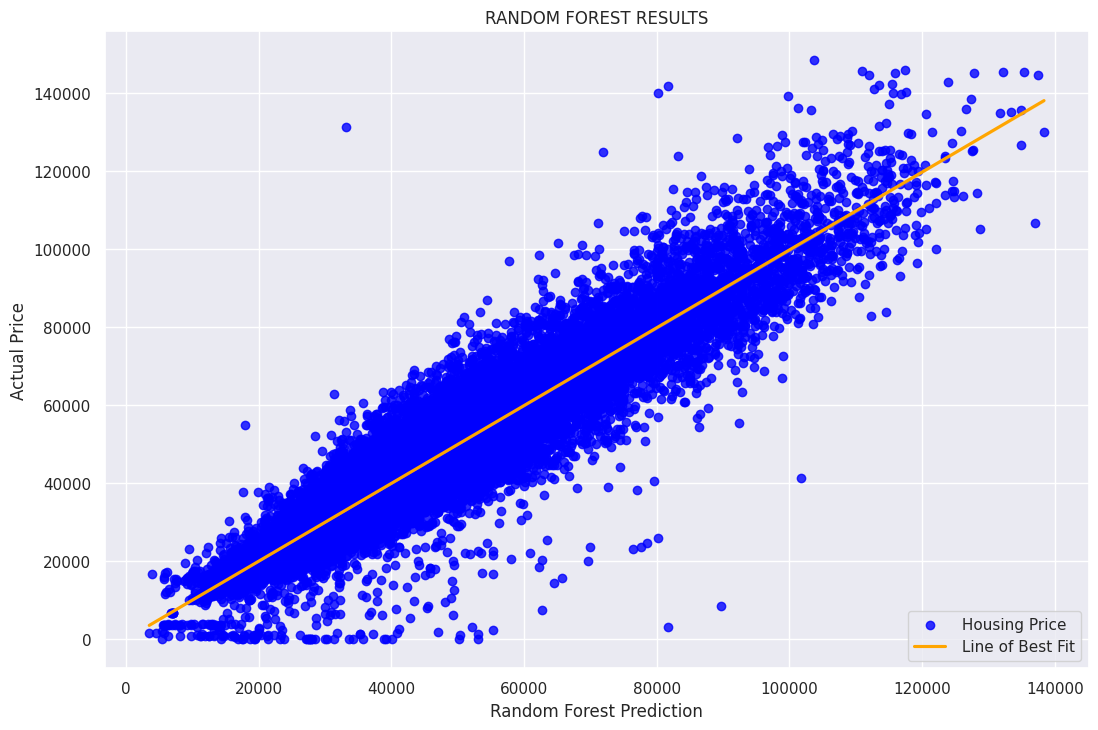

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with your data
data = pd.DataFrame({'Random Forest Prediction': pred_y, 'Actual Price': test_y})

# Now use the DataFrame in regplot, specifying the x and y columns
sns.set(rc={'figure.figsize':(12.7,8.27)})
ax = sns.regplot(x='Random Forest Prediction', y='Actual Price', data=data,
                color='blue', line_kws={'color':'orange'})

ax.set(xlabel="Random Forest Prediction", ylabel="Actual Price",
       title="RANDOM FOREST RESULTS")
ax.legend([' Housing Price', ' Line of Best Fit'], loc='lower right')
plt.show()

In [ ]:
# HUẤN LUYỆN MODEL RANDOMFOREST TRÊN TẬP THỬ NGHIỆM

rf = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                            n_jobs=-1, min_samples_split=10)
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict(X_test)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_2 = np.sqrt(mean_squared_log_error(y_pred, y_test))
mae_2 = mean_absolute_error(y_test, y_pred)
r2_2 = r2_score(y_test, y_pred)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred))

# IN CÁC GIÁ TRỊ ĐÁNH GIÁ
print("RMSLE: {:,.5f}".format(rmsle_2))
print("MAE: {:,.5f}".format(mae_2))
print("R²: {:,.5f}".format(r2_2))
print("RMSE: {:,.5f}".format(rmse_2))

RMSLE: 0.30224
MAE: 3,938.19175
R²: 0.90165
RMSE: 5,974.04954


# **SO SÁNH KẾT QUẢ**

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE', 'RMSE', 'R²'],
    'Training Set': [rmsle_1, mae_1, rmse_1, r2_1],
    'Test Set': [rmsle_2, mae_2, rmse_2, r2_2]
})


# In bảng so sánh
print(comparison_df)

  Metric  Training Set     Test Set
0  RMSLE      0.292380     0.302242
1    MAE   4014.564115  3938.191753
2   RMSE   6018.480030  5974.049535
3     R²      0.902919     0.901646


# **THỬ NGHIỆM DỰ ĐOÁN**

In [ ]:

rf.fit(X_train_scaled, y_train)

# Hàm dự đoán giá
def predict_price(lng, lat, trade_time, followers, square, living_room,
                  building_type, renovation_condition, building_structure,
                  ladder_ratio, elevator, five_years_property, subway,
                  district, community_average, distance, age, floor_type, floor_height):

    # Bước 1: Chuẩn bị dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height],
    }

    input_df = pd.DataFrame(input_data)

    # Bước 2: Tiền xử lý dữ liệu
    input_scaled = scaler.transform(input_df)

    # Bước 3: Dự đoán với mô hình
    predicted_price = rf.predict(input_scaled)

    # Hiển thị kết quả
    print("Dự đoán giá (price):", predicted_price[0])

# Tạo các ô nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='5 Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')

# Nút dự đoán
predict_button = widgets.Button(description='Dự đoán Giá')

# Hàm xử lý sự kiện khi nhấn nút
def on_predict_button_clicked(b):
    predict_price(lng.value, lat.value, trade_time.value, followers.value,
                  square.value, living_room.value, building_type.value,
                  renovation_condition.value, building_structure.value,
                  ladder_ratio.value, elevator.value, five_years_property.value,
                  subway.value, district.value, community_average.value,
                  distance.value, age.value, floor_type.value, floor_height.value)

predict_button.on_click(on_predict_button_clicked)

# Hiển thị các ô nhập liệu và nút
display(lng, lat, trade_time, followers, square, living_room,
        building_type, renovation_condition, building_structure,
        ladder_ratio, elevator, five_years_property, subway,
        district, community_average, distance, age, floor_type,
        floor_height, predict_button)


FloatText(value=0.0, description='Lng:')

FloatText(value=0.0, description='Lat:')

FloatText(value=0.0, description='Trade Time:')

FloatText(value=0.0, description='Followers:')

FloatText(value=0.0, description='Square:')

FloatText(value=0.0, description='Living Room:')

FloatText(value=0.0, description='Building Type:')

FloatText(value=0.0, description='Renovation Condition:')

FloatText(value=0.0, description='Building Structure:')

FloatText(value=0.0, description='Ladder Ratio:')

FloatText(value=0.0, description='Elevator:')

FloatText(value=0.0, description='5 Years Property:')

FloatText(value=0.0, description='Subway:')

FloatText(value=0.0, description='District:')

FloatText(value=0.0, description='Community Average:')

FloatText(value=0.0, description='Distance:')

FloatText(value=0.0, description='Age:')

FloatText(value=0.0, description='Floor Type:')

FloatText(value=0.0, description='Floor Height:')

Button(description='Dự đoán Giá', style=ButtonStyle())

Dự đoán giá (price): 26770.205189742912


In [ ]:
X_test[1]

array([-2.20193506, -0.12830347, -0.38779592, -0.69077967, -0.10794228,
        0.06847729,  0.44459722,  0.3495918 ,  0.79930767, -0.58693598,
        0.85473784,  0.73502919,  0.81453995,  1.06244262, -0.87021911,
        0.72792677,  0.68052806,  0.65991125, -0.28537158])

In [ ]:
y_test[1]

24127.0

# **LIGHTGBM**

In [ ]:
# HUẤN LUYỆN MÔ HÌNH LGBM TRÊN TẬP HUẤN LUYỆN
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=36,
                        learning_rate=0.15,
                        n_estimators=64,
                        min_child_weight=2,
                        colsample_bytree=0.8,
                        reg_lambda=0.45)
gbm.fit(train_X, train_y,
        eval_set=[(test_X, test_y)],
        eval_metric='l2_root',
        callbacks=[early_stopping(stopping_rounds=50)])
pred_y = gbm.predict(test_X, num_iteration=gbm.best_iteration_)

#ĐÁNH GIÁ MÔ HÌNH
rmsle_3 = np.sqrt(mean_squared_log_error(pred_y, test_y))
mae_3 = mean_absolute_error(test_y, pred_y)
r2_3 = r2_score(test_y, pred_y)
rmse_3 = np.sqrt(mean_squared_error(test_y, pred_y))

#IN KẾT QUẢ
print("RMSLE {:,.5f}".format(rmsle_3))
print("MAE {:,.5f}".format(mae_3))
print("R² {:,.5f}".format(r2_3))
print("RMSE: {:,.5f}".format(rmse_3))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 123339, number of used features: 19
[LightGBM] [Info] Start training from score 41028.655056
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's rmse: 6224.2	valid_0's l2: 3.87407e+07
RMSLE 0.29676
MAE 4,260.43169
R² 0.89617
RMSE: 6,224.20005


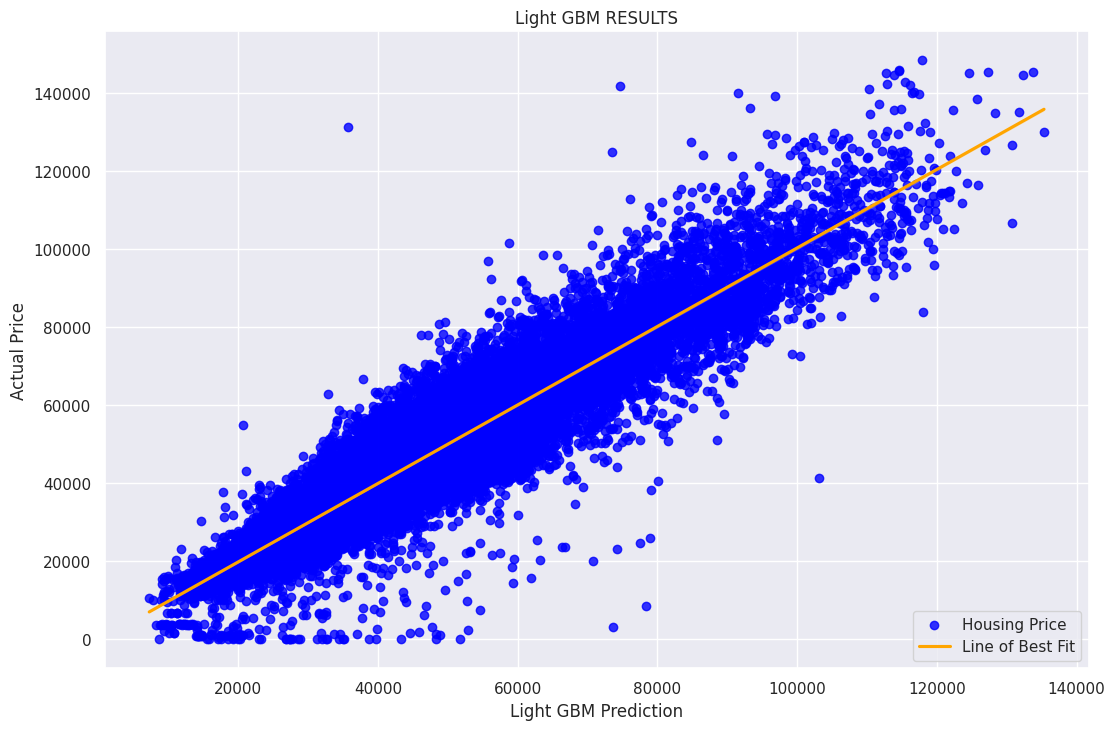

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for DataFrame creation

sns.set(rc={'figure.figsize': (12.7, 8.27)})

# Create a DataFrame from pred_y and test_y
data = pd.DataFrame({'Light GBM Prediction': pred_y, 'Actual Price': test_y})

# Use the DataFrame in regplot, specifying 'x' and 'y' with column names
ax = sns.regplot(x='Light GBM Prediction', y='Actual Price', data=data,
                color='blue', line_kws={'color': 'orange'})

ax.set(xlabel="Light GBM Prediction", ylabel="Actual Price", title="Light GBM RESULTS")
ax.legend(['Housing Price', 'Line of Best Fit'], loc='lower right')
plt.show()

In [ ]:
# HUẤN LUYỆN MÔ HÌNH LGBM TRÊN TẬP THỬ NGHIỆM
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=36,
                        learning_rate=0.15,
                        n_estimators=64,
                        min_child_weight=2,
                        colsample_bytree=0.8,
                        reg_lambda=0.45)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2_root',
        callbacks=[early_stopping(stopping_rounds=50)])
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

#ĐÁNH GIÁ MÔ HÌNH
rmsle_4 = np.sqrt(mean_squared_log_error(y_pred, y_test))
mae_4 = mean_absolute_error(y_test, y_pred)
r2_4 = r2_score(y_test, y_pred)
rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred))

#IN KẾT QUẢ ĐÁNH GIÁ
print("RMSLE {:,.5f}".format(rmsle_4))
print("MAE {:,.5f}".format(mae_4))
print("R² {:,.5f}".format(r2_4))
print("RMSE: {:,.5f}".format(rmse_4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 164453, number of used features: 19
[LightGBM] [Info] Start training from score 41059.530948
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's rmse: 6261.41	valid_0's l2: 3.92053e+07
RMSLE 0.30774
MAE 4,256.89622
R² 0.89196
RMSE: 6,261.41129


# **SO SÁNH KẾT QUẢ**

In [ ]:
# Tạo DataFrame để so sánh
comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE','RMSE', 'R²'],
    'Training Set': [rmsle_3, mae_3, rmse_3, r2_3],
    'Test Set': [rmsle_4, mae_4, rmse_4, r2_4]
})

# In bảng so sánh
print(comparison_df)

  Metric  Training Set     Test Set
0  RMSLE      0.296758     0.307740
1    MAE   4260.431695  4256.896222
2   RMSE   6224.200045  6261.411288
3     R²      0.896168     0.891957


# **CHẠY THỬ NGHIỆM DỰ ĐOÁN**

In [ ]:
# Hàm dự đoán giá trị 'price' dựa trên mô hình LightGBM
def predict_price_lgb(lng, lat, trade_time, followers, square, living_room, building_type,
                      renovation_condition, building_structure, ladder_ratio, elevator,
                      five_years_property, subway, district, community_average, distance,
                      age, floor_type, floor_height):

    # Tạo DataFrame từ dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height]
    }

    input_df = pd.DataFrame(input_data)

    # Tiền xử lý dữ liệu (chuẩn hóa)
    input_scaled = scaler.transform(input_df)

    # Dự đoán với mô hình LightGBM
    predicted_price = gbm.predict(input_scaled, num_iteration=gbm.best_iteration_)
    print(f"Predicted Price: {predicted_price[0]:,.2f}")

# Tạo giao diện nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='Five Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')

button = widgets.Button(description="Dự đoán giá")

# Hàm xử lý khi nhấn nút "Predict Price"
def on_predict_button_clicked(b):
    predict_price_lgb(lng.value, lat.value, trade_time.value, followers.value,
                      square.value, living_room.value, building_type.value,
                      renovation_condition.value, building_structure.value,
                      ladder_ratio.value, elevator.value, five_years_property.value,
                      subway.value, district.value, community_average.value,
                      distance.value, age.value, floor_type.value, floor_height.value)
button.on_click(on_predict_button_clicked)

# Hiển thị giao diện
display(widgets.VBox([lng, lat, trade_time, followers, square, living_room, building_type,
                      renovation_condition, building_structure, ladder_ratio, elevator,
                      five_years_property, subway, district, community_average, distance,
                      age, floor_type, floor_height, button]))


In [ ]:
X_test[1]

array([-2.20193506, -0.12830347, -0.38779592, -0.69077967, -0.10794228,
        0.06847729,  0.44459722,  0.3495918 ,  0.79930767, -0.58693598,
        0.85473784,  0.73502919,  0.81453995,  1.06244262, -0.87021911,
        0.72792677,  0.68052806,  0.65991125, -0.28537158])

In [ ]:
y_test[1]

24127.0

# **XGBOOST**

In [ ]:
import xgboost as xgb
# HUẤN LUYỆN MÔ HÌNH XGBOOST TRÊN TẬP HUẤN LUYỆN
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                          colsample_bytree=0.8, learning_rate=0.2, n_estimators=500,
                          reg_lambda=0.45, reg_alpha=0, gamma=0.5)
xg_reg.fit(train_X, train_y)
pred_y = xg_reg.predict(test_X)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_5 = np.sqrt(mean_squared_log_error(pred_y, test_y))
mae_5 = mean_absolute_error(test_y, pred_y)
r2_5 = r2_score(test_y, pred_y)
rmse_5 = np.sqrt(mean_squared_error(test_y, pred_y))

# IN RA KẾT QUẢ ĐÁNH GIÁ
print(f"RMSLE: {rmsle_5:,.5f}")
print(f"MAE: {mae_5:,.2f}")
print(f"R²: {r2_5:.5f}")
print("RMSE: {:,.5f}".format(rmse_5))

RMSLE: 0.29114
MAE: 3,927.95
R²: 0.90831
RMSE: 5,848.98126


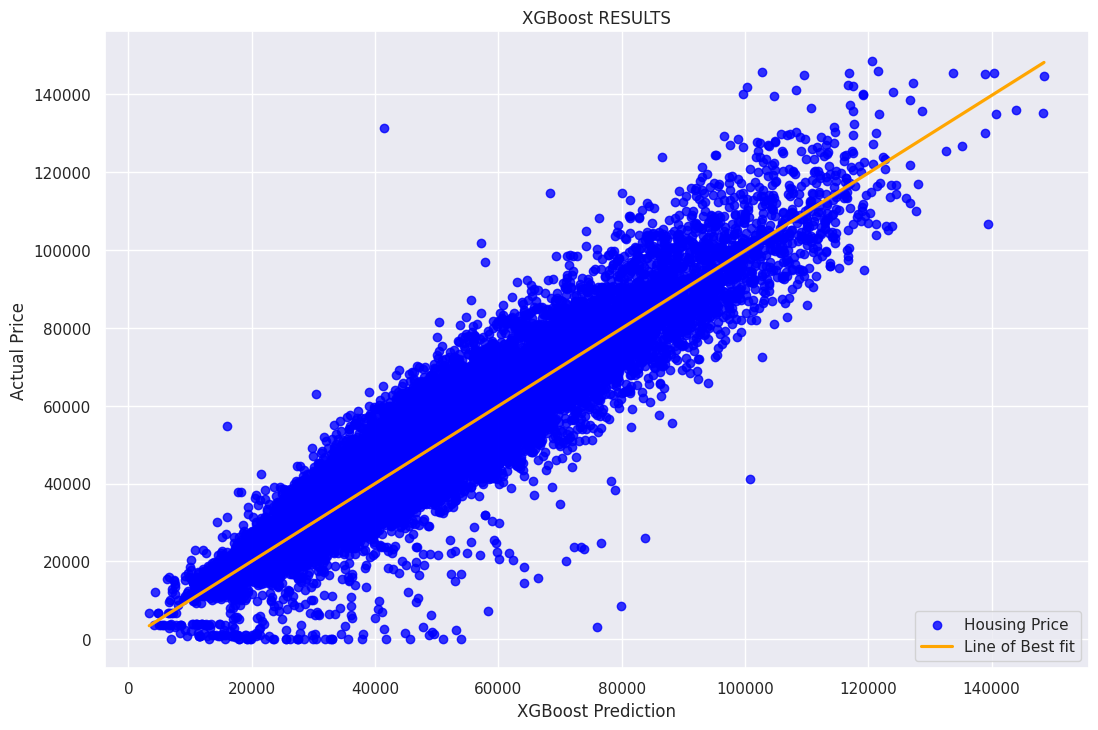

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for DataFrame creation

sns.set(rc={'figure.figsize':(12.7,8.27)})

# Create a DataFrame with 'XGBoost Prediction' and 'Actual Price' columns
data = pd.DataFrame({'XGBoost Prediction': pred_y, 'Actual Price': test_y})

# Use the DataFrame in regplot with 'x' and 'y' keyword arguments
ax = sns.regplot(x='XGBoost Prediction', y='Actual Price', data=data,
                 color='blue', line_kws={'color':'orange'})

ax.set(xlabel="XGBoost Prediction", ylabel = "Actual Price",title = "XGBoost RESULTS")
ax.legend(['Housing Price', 'Line of Best fit'], loc='lower right')
plt.show()

In [ ]:
# HUẤN LUYỆN MÔ HÌNH XGBOOST TRÊN TẬP THỬ NGHIỆM
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                          colsample_bytree=0.8, learning_rate=0.2, n_estimators=500,
                          reg_lambda=0.45, reg_alpha=0, gamma=0.5)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_6 = np.sqrt(mean_squared_log_error(y_pred, y_test))
mae_6 = mean_absolute_error(y_test, y_pred)
r2_6 = r2_score(y_test, y_pred)
rmse_6 = np.sqrt(mean_squared_error(y_test, y_pred))

# IN CÁC CHỈ SỐ ĐÁNH GIÁ
print(f"RMSLE: {rmsle_6:,.5f}")
print(f"MAE: {mae_6:,.2f}")
print(f"R²: {r2_6:.5f}")
print("RMSE: {:,.5f}".format(rmse_6))

RMSLE: 0.30221
MAE: 3,901.23
R²: 0.90491
RMSE: 5,874.20196


# **SO SÁNH KẾT QUẢ**

In [ ]:
# Tạo DataFrame để so sánh
comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE','RMSE', 'R²'],
    'Training Set': [rmsle_5, mae_5, rmse_5, r2_5],
    'Test Set': [rmsle_6, mae_6, rmse_6, r2_6]
})
# In bảng so sánh
print(comparison_df)

  Metric  Training Set     Test Set
0  RMSLE      0.291142     0.302213
1    MAE   3927.947260  3901.234011
2   RMSE   5848.981256  5874.201962
3     R²      0.908310     0.904907


# **CHẠY THỬ NGHIỆM DỰ ĐOÁN**

In [ ]:
# Hàm dự đoán giá trị 'price' dựa trên mô hình XGBoost
def predict_price_xgb(lng, lat, trade_time, followers, square, living_room, building_type,
                      renovation_condition, building_structure, ladder_ratio, elevator,
                      five_years_property, subway, district, community_average, distance,
                      age, floor_type, floor_height):

    # Tạo DataFrame từ dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height]
    }

    input_df = pd.DataFrame(input_data)

    # Tiền xử lý dữ liệu (chuẩn hóa)
    input_scaled = scaler.transform(input_df)

    # Dự đoán với mô hình XGBoost
    predicted_price = xg_reg.predict(input_scaled)
    print(f"Predicted Price: {predicted_price[0]:,.2f}")

# Tạo giao diện nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='Five Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')

button = widgets.Button(description="Dự đoán giá")

# Hàm xử lý khi nhấn nút "Predict Price"
def on_predict_button_clicked(b):
    predict_price_xgb(lng.value, lat.value, trade_time.value, followers.value,
                      square.value, living_room.value, building_type.value,
                      renovation_condition.value, building_structure.value,
                      ladder_ratio.value, elevator.value, five_years_property.value,
                      subway.value, district.value, community_average.value,
                      distance.value, age.value, floor_type.value, floor_height.value)
button.on_click(on_predict_button_clicked)

# Hiển thị giao diện
display(widgets.VBox([lng, lat, trade_time, followers, square, living_room, building_type,
                      renovation_condition, building_structure, ladder_ratio, elevator,
                      five_years_property, subway, district, community_average, distance,
                      age, floor_type, floor_height, button]))


Predicted Price: 24,756.68


In [ ]:
X_test[1]

array([-2.20193506, -0.12830347, -0.38779592, -0.69077967, -0.10794228,
        0.06847729,  0.44459722,  0.3495918 ,  0.79930767, -0.58693598,
        0.85473784,  0.73502919,  0.81453995,  1.06244262, -0.87021911,
        0.72792677,  0.68052806,  0.65991125, -0.28537158])

In [ ]:
y_test[1]

24127.0

# **HYBRID REGRESSION**

In [ ]:
# HUẤN LUYỆN MODEL HYBRID TRÊN TẬP HUẤN LUYỆN
# Model 1
r1 = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                       colsample_bytree=0.8, learning_rate=0.2, n_estimators=500,
                       reg_lambda=0.45, reg_alpha=0, gamma=0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression', num_leaves=36, learning_rate=0.15,
                        n_estimators=64, min_child_weight=2, colsample_bytree=0.8,
                        reg_lambda=0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                           n_jobs=-1, min_samples_split=10)

vreg = VotingRegressor([('xgb', r1), ('lgb', r2), ('rf', r3)])
vreg.fit(train_X, train_y)
pred_y = vreg.predict(test_X)

#ĐÁNH GIÁ MÔ HÌNH
rmsle_7 = np.sqrt(mean_squared_log_error(pred_y, test_y))
mae_7 = mean_absolute_error(test_y, pred_y)
r2_7 = r2_score(test_y, pred_y)
rmse_7 = np.sqrt(mean_squared_error(test_y, pred_y))

#IN RA KẾT QUẢ ĐÁNH GIÁ
print("RMSLE: {:,.5f}".format(rmsle_7))
print("MAE: {:,.5f}".format(mae_7))
print("R²: {:,.5f}".format(r2_7))
print("RMSE: {:,.5f}".format(rmse_7))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 123339, number of used features: 19
[LightGBM] [Info] Start training from score 41028.655056
RMSLE: 0.29139
MAE: 3,934.40918
R²: 0.90763
RMSE: 5,870.74440


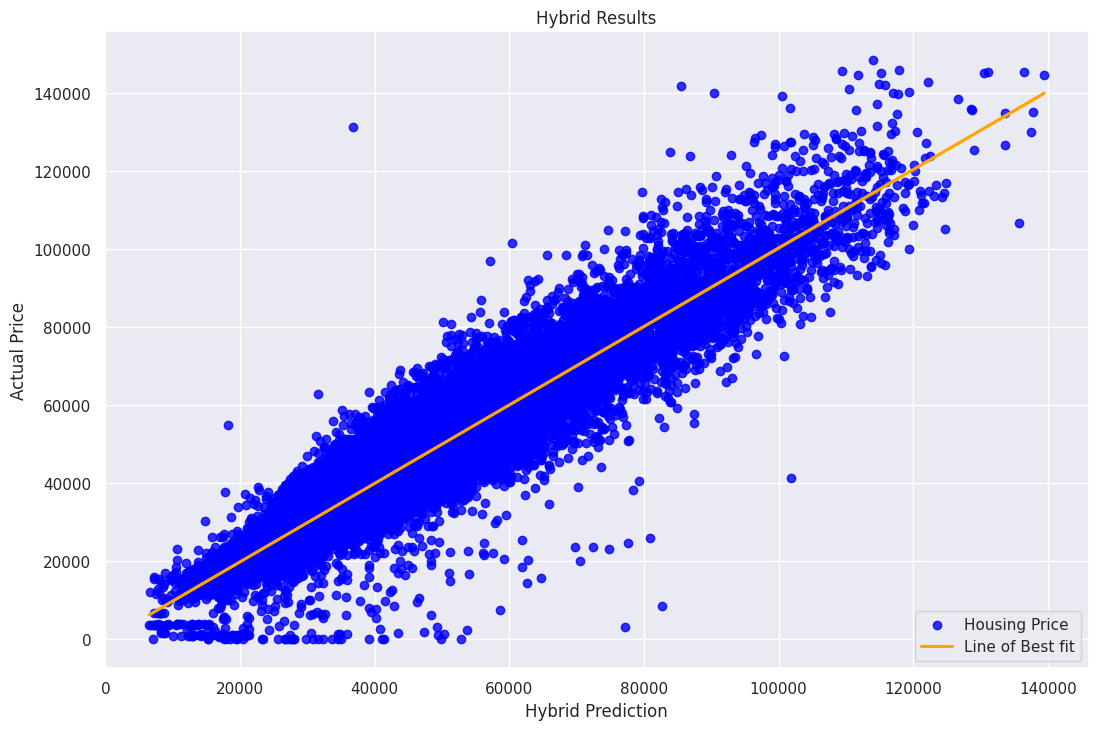

In [ ]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
# Pass data as a dictionary-like object with specified 'x' and 'y'
ax = sns.regplot(x=pred_y, y=test_y, color='blue', line_kws={'color':'orange'})

ax.set(xlabel="Hybrid Prediction", ylabel="Actual Price", title="Hybrid Results")
ax.legend(['Housing Price', 'Line of Best fit'], loc='lower right')

In [ ]:
# HUẤN LUYỆN MODEL HYBRID TRÊN TẬP THỬ NGHIỆM
# Model 1
r1 = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                       colsample_bytree=0.8, learning_rate=0.2, n_estimators=500,
                       reg_lambda=0.45, reg_alpha=0, gamma=0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression', num_leaves=36, learning_rate=0.15,
                        n_estimators=64, min_child_weight=2, colsample_bytree=0.8,
                        reg_lambda=0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                           n_jobs=-1, min_samples_split=10)

vreg = VotingRegressor([('xgb', r1), ('lgb', r2), ('rf', r3)])
vreg.fit(X_train, y_train)
y_pred = vreg.predict(X_test)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_8 = np.sqrt(mean_squared_log_error(y_pred, y_test))
mae_8 = mean_absolute_error(y_test, y_pred)
r2_8 = r2_score(y_test, y_pred)
rmse_8 = np.sqrt(mean_squared_error(y_test, y_pred))

# IN RA KẾT QUẢ ĐÁNH GIÁ
print("RMSLE: {:,.5f}".format(rmsle_8))
print("MAE: {:,.5f}".format(mae_8))
print("R²: {:,.5f}".format(r2_8))
print("RMSE: {:,.5f}".format(rmse_8))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 164453, number of used features: 19
[LightGBM] [Info] Start training from score 41059.530948
RMSLE: 0.30215
MAE: 3,901.83283
R²: 0.90463
RMSE: 5,882.60393


# **SO SÁNH KẾT QUẢ**

In [ ]:
# Tạo DataFrame để so sánh
comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE','RMSE', 'R²'],
    'Training Set': [rmsle_7, mae_7, rmse_7, r2_7],
    'Test Set': [rmsle_8, mae_8, rmse_8, r2_8]
})
# In bảng so sánh
print(comparison_df)

  Metric  Training Set     Test Set
0  RMSLE      0.291395     0.302147
1    MAE   3934.409180  3901.832832
2   RMSE   5870.744403  5882.603926
3     R²      0.907626     0.904634


# **CHẠY THỬ NGHIỆM DỰ ĐOÁN**

In [ ]:
# Hàm dự đoán giá trị 'price' dựa trên mô hình Hybrid
def predict_price_hybrid(lng, lat, trade_time, followers, square, living_room, building_type,
                          renovation_condition, building_structure, ladder_ratio, elevator,
                          five_years_property, subway, district, community_average, distance,
                          age, floor_type, floor_height):
    # Tạo DataFrame từ dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height]
    }
    input_df = pd.DataFrame(input_data)

    # Tiền xử lý dữ liệu (chuẩn hóa)
    input_scaled = scaler.transform(input_df)

    # Dự đoán với mô hình Hybrid
    predicted_price = vreg.predict(input_scaled)
    print(f"Predicted Price: {predicted_price[0]:,.2f}")

# Tạo giao diện nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='Five Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')


button = widgets.Button(description="Dự đoán giá")


# Hàm xử lý khi nhấn nút "Predict Price"
def on_predict_button_clicked(b):
    predict_price_hybrid(lng.value, lat.value, trade_time.value, followers.value,
                          square.value, living_room.value, building_type.value,
                          renovation_condition.value, building_structure.value,
                          ladder_ratio.value, elevator.value, five_years_property.value,
                          subway.value, district.value, community_average.value,
                          distance.value, age.value, floor_type.value, floor_height.value)
button.on_click(on_predict_button_clicked)
# Hiển thị giao diện
display(widgets.VBox([lng, lat, trade_time, followers, square, living_room, building_type,
                      renovation_condition, building_structure, ladder_ratio, elevator,
                      five_years_property, subway, district, community_average, distance,
                      age, floor_type, floor_height, button]))


Predicted Price: 26,087.37


In [ ]:
X_test[1]

array([-2.20193506, -0.12830347, -0.38779592, -0.69077967, -0.10794228,
        0.06847729,  0.44459722,  0.3495918 ,  0.79930767, -0.58693598,
        0.85473784,  0.73502919,  0.81453995,  1.06244262, -0.87021911,
        0.72792677,  0.68052806,  0.65991125, -0.28537158])

In [ ]:
y_test[1]

24127.0

# **STACKED GENERALIZATION**

In [ ]:
# HUẤN LUYỆN MÔ HÌNH STACKED GENERALIZATION TRÊN TẬP HUẤN LUYỆN
# Model 1
r1 = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                       colsample_bytree=0.8,
                       learning_rate=0.2, n_estimators=500,
                       reg_lambda=0.45, reg_alpha=0, gamma=0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression', num_leaves=36, learning_rate=0.15,
                        n_estimators=64, min_child_weight=2, colsample_bytree=0.8,
                        reg_lambda=0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                           n_jobs=-1, min_samples_split=10)
estimators = [('xgb', r1), ('lgb', r2)]
sreg = StackingRegressor(estimators=estimators, final_estimator=r3)
sreg.fit(train_X, train_y)
pred_y = sreg.predict(test_X)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_9 = np.sqrt(mean_squared_log_error(pred_y, test_y))
mae_9 = mean_absolute_error(test_y, pred_y)
r2_9 = r2_score(test_y, pred_y)
rmse_9 = np.sqrt(mean_squared_error(test_y, pred_y))
#IN RA CÁC GIÁ TRỊ
print(f"RMSLE: {rmsle_9:,.5f}")
print(f"MAE: {mae_9:,.5f}")
print(f"R-squared: {r2_9:,.5f}")
print("RMSE: {:,.5f}".format(rmse_9))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 123339, number of used features: 19
[LightGBM] [Info] Start training from score 41028.655056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 98671, number of used features: 19
[LightGBM] [Info] Start training from score 41020.983156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

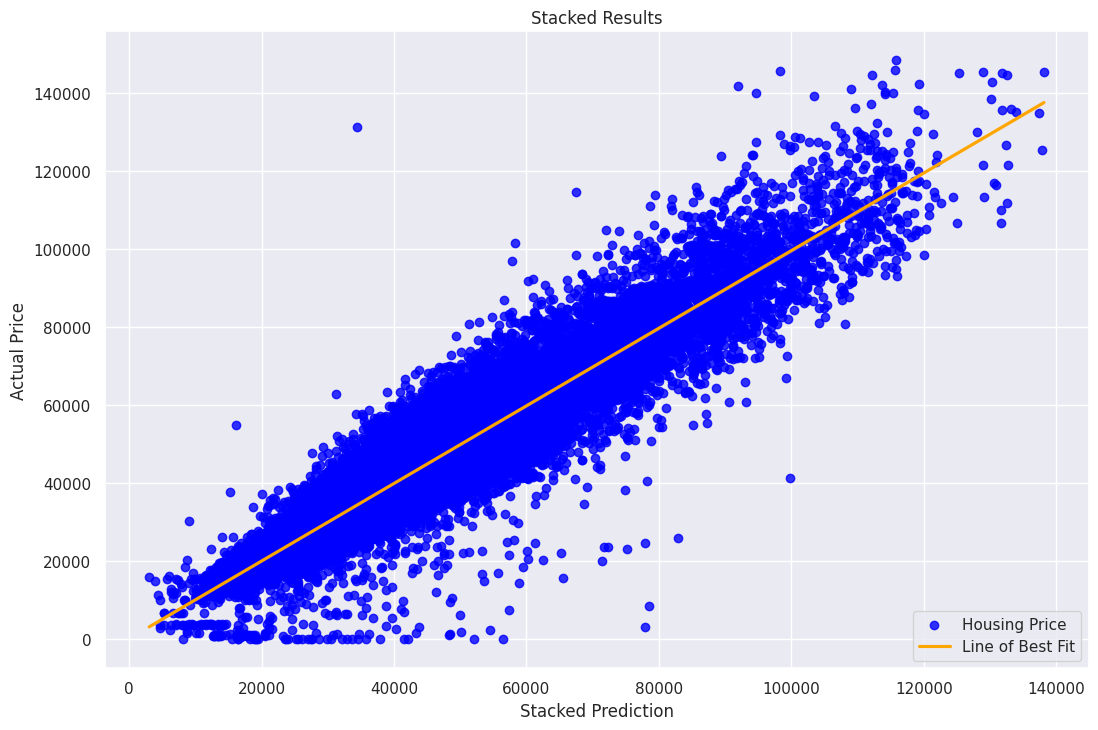

In [ ]:
sns.set(rc={'figure.figsize':(12.7,8.27)})
# Pass data using x and y keywords
ax = sns.regplot(x=pred_y, y=test_y, color='blue', line_kws={'color':'orange'}) # Changed this line

ax.set(xlabel="Stacked Prediction", ylabel = "Actual Price",title = "Stacked Results")
ax.legend([ 'Housing Price', 'Line of Best Fit'], loc='lower right')

In [ ]:
# HUẤN LUYỆN MÔ HÌNH STACKED TRÊN TẬP THỬ NGHIỆM
# Model 1
r1 = xgb.XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                       colsample_bytree=0.8,
                       learning_rate=0.2, n_estimators=500,
                       reg_lambda=0.45, reg_alpha=0, gamma=0.5)
# Model 2
r2 = lgb.LGBMRegressor(objective='regression', num_leaves=36, learning_rate=0.15,
                        n_estimators=64, min_child_weight=2, colsample_bytree=0.8,
                        reg_lambda=0.45)
# Model 3
r3 = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                           n_jobs=-1, min_samples_split=10)
estimators = [('xgb', r1), ('lgb', r2)]
sreg = StackingRegressor(estimators=estimators, final_estimator=r3)
sreg.fit(X_train, y_train)
y_pred = sreg.predict(X_test)

# ĐÁNH GIÁ MÔ HÌNH
rmsle_10 = np.sqrt(mean_squared_log_error(y_pred, y_test))
mae_10 = mean_absolute_error(y_test, y_pred)
r2_10 = r2_score(y_test, y_pred)
rmse_10 = np.sqrt(mean_squared_error(y_test, y_pred))

# IN RA KẾT QUẢ ĐÁNH GIÁ
print(f"RMSLE: {rmsle_10:,.5f}")
print(f"MAE: {mae_10:,.5f}")
print(f"R-squared: {r2_10:,.5f}")
print("RMSE: {:,.5f}".format(rmse_10))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 164453, number of used features: 19
[LightGBM] [Info] Start training from score 41059.530948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the train set: 131562, number of used features: 19
[LightGBM] [Info] Start training from score 41067.859967
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

# **SO SÁNH KẾT QUẢ**

In [ ]:
# Tạo DataFrame để so sánh
comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE','RMSE', 'R²'],
    'Training Set': [rmsle_9, mae_9, rmse_9, r2_9],
    'Test Set': [rmsle_10, mae_10, rmse_10, r2_10]
})
# In bảng so sánh
print(comparison_df)

  Metric  Training Set     Test Set
0  RMSLE      0.293242     0.303489
1    MAE   4033.032068  3980.849825
2   RMSE   5987.736419  5976.234993
3     R²      0.903908     0.901574


# **CHẠY THỬ NGHIỆM DỰ ĐOÁN**

In [ ]:
# Hàm dự đoán giá trị 'price' dựa trên mô hình Stacked
def predict_price_stacked(lng, lat, trade_time, followers, square, living_room, building_type,
                           renovation_condition, building_structure, ladder_ratio, elevator,
                           five_years_property, subway, district, community_average, distance,
                           age, floor_type, floor_height):

    # Tạo DataFrame từ dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height]
    }

    input_df = pd.DataFrame(input_data)

    # Tiền xử lý dữ liệu (chuẩn hóa)
    input_scaled = scaler.transform(input_df)  # Sử dụng scaler từ quá trình training trước đó

    # Dự đoán với mô hình Stacked
    predicted_price = sreg.predict(input_scaled)  # Sử dụng input_scaled đã được chuẩn hóa
    print(f"Predicted Price: {predicted_price[0]:,.2f}")

# Tạo giao diện nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='Five Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')

button = widgets.Button(description="Dự đoán giá")

# Hàm xử lý khi nhấn nút "Predict Price"
def on_predict_button_clicked(b):
    predict_price_stacked(lng.value, lat.value, trade_time.value, followers.value,
                          square.value, living_room.value, building_type.value,
                          renovation_condition.value, building_structure.value,
                          ladder_ratio.value, elevator.value, five_years_property.value,
                          subway.value, district.value, community_average.value,
                          distance.value, age.value, floor_type.value, floor_height.value)

button.on_click(on_predict_button_clicked)

# Hiển thị giao diện
display(widgets.VBox([lng, lat, trade_time, followers, square, living_room, building_type,
                      renovation_condition, building_structure, ladder_ratio, elevator,
                      five_years_property, subway, district, community_average, distance,
                      age, floor_type, floor_height, button]))

Predicted Price: 25,590.49


In [ ]:
X_test[1]

array([-2.20193506, -0.12830347, -0.38779592, -0.69077967, -0.10794228,
        0.06847729,  0.44459722,  0.3495918 ,  0.79930767, -0.58693598,
        0.85473784,  0.73502919,  0.81453995,  1.06244262, -0.87021911,
        0.72792677,  0.68052806,  0.65991125, -0.28537158])

In [ ]:
y_test[1]

24127.0

# **SO SÁNH CÁC THUẬT TOÁN**

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE', 'RMSE', 'R²'],
    'RANDOM FOREST': [rmsle_2, mae_2, rmse_2, r2_2],
    'LIGHGBM': [rmsle_4, mae_4, rmse_4, r2_4],
    'XGBOOST': [rmsle_6, mae_6, rmse_6, r2_6],
    'HYBRID REGRESSION': [rmsle_8, mae_8, rmse_8, r2_8],
    'STACKED GENERALIZATION': [rmsle_10, mae_10, rmse_10, r2_10]
})

# In bảng so sánh
print(comparison_df)

  Metric  RANDOM FOREST      LIGHGBM      XGBOOST  HYBRID REGRESSION  STACKED GENERALIZATION
0  RMSLE       0.302242     0.307740     0.302213           0.302147                0.303489
1    MAE    3938.191753  4256.896222  3901.234011        3901.832832             3980.849825
2   RMSE    5974.049535  6261.411288  5874.201962        5882.603926             5976.234993
3     R²       0.901646     0.891957     0.904907           0.904634                0.901574


In [ ]:
# prompt: xuất ra dạng data frame với 5 chữ số thập phân
# comparison_df = pd.DataFrame({
#     'Metric': ['RMSLE', 'MAE', 'RMSE', 'R²'],
#     'RANDOM FOREST': [rmsle_2, mae_2, rmse_2, r2_2],
#     'LIGHGBM': [rmsle_4, mae_4, rmse_4, r2_4],
#     'XGBOOST': [rmsle_6, mae_6, rmse_6, r2_6],
#     'HYBRID REGRESSION': [rmsle_8, mae_8, rmse_8, r2_8],
#     'STACKED GENERALIZATION': [rmsle_10, mae_10, rmse_10, r2_10]

comparison_df = pd.DataFrame({
    'Metric': ['RMSLE', 'MAE', 'RMSE', 'R²'],
    'RANDOM FOREST': [rmsle_2, mae_2, rmse_2, r2_2],
    'LIGHGBM': [rmsle_4, mae_4, rmse_4, r2_4],
    'XGBOOST': [rmsle_6, mae_6, rmse_6, r2_6],
    'HYBRID REGRESSION': [rmsle_8, mae_8, rmse_8, r2_8],
    'STACKED GENERALIZATION': [rmsle_10, mae_10, rmse_10, r2_10]
})

# Display the DataFrame with 5 decimal places
pd.options.display.float_format = '{:,.5f}'.format
comparison_df

,Metric,RANDOM FOREST,LIGHGBM,XGBOOST,HYBRID REGRESSION,STACKED GENERALIZATION
0,RMSLE,0.30224,0.30774,0.30221,0.30215,0.30349
1,MAE,"3,938.19175","4,256.89622","3,901.23401","3,901.83283","3,980.84982"
2,RMSE,"5,974.04954","6,261.41129","5,874.20196","5,882.60393","5,976.23499"
3,R²,0.90165,0.89196,0.90491,0.90463,0.90157


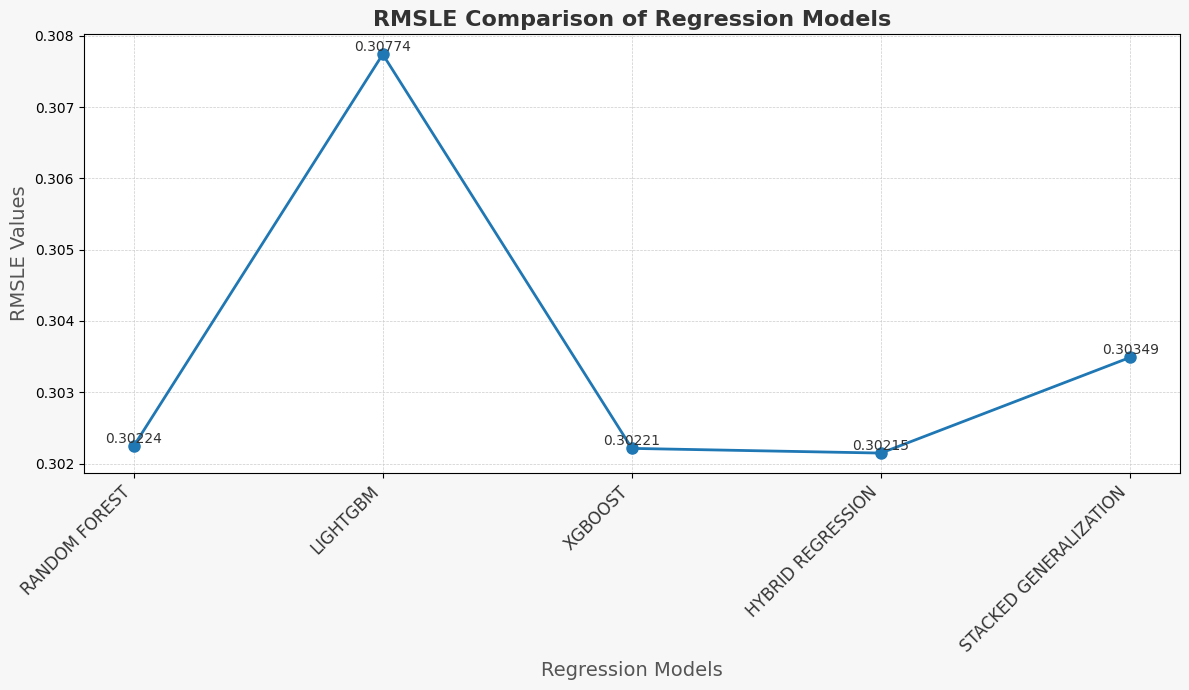

In [ ]:
# BIỂU ĐỒ SO SÁNH RMSLE
import matplotlib.pyplot as plt

models = ['RANDOM FOREST', 'LIGHTGBM', 'XGBOOST', 'HYBRID REGRESSION', 'STACKED GENERALIZATION']
rmsle_values = [rmsle_2, rmsle_4, rmsle_6, rmsle_8, rmsle_10]

plt.figure(figsize=(12, 7), facecolor='#f7f7f7')
plt.plot(models, rmsle_values, marker='o', linestyle='-', color='#1f77b4', markersize=8, linewidth=2)

# Thêm tiêu đề và nhãn
plt.title('RMSLE Comparison of Regression Models', fontsize=16, color='#333333', fontweight='bold')
plt.xlabel('Regression Models', fontsize=14, color='#555555')
plt.ylabel('RMSLE Values', fontsize=14, color='#555555')

# Lưới và các tùy chỉnh khác
plt.grid(color='#cccccc', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12, color='#333333')

# Thêm chú thích giá trị cho từng điểm với 5 chữ số thập phân
for i, value in enumerate(rmsle_values):
    plt.text(i, value, f'{value:.5f}', ha='center', va='bottom', fontsize=10, color='#333333')

plt.tight_layout()
plt.show()

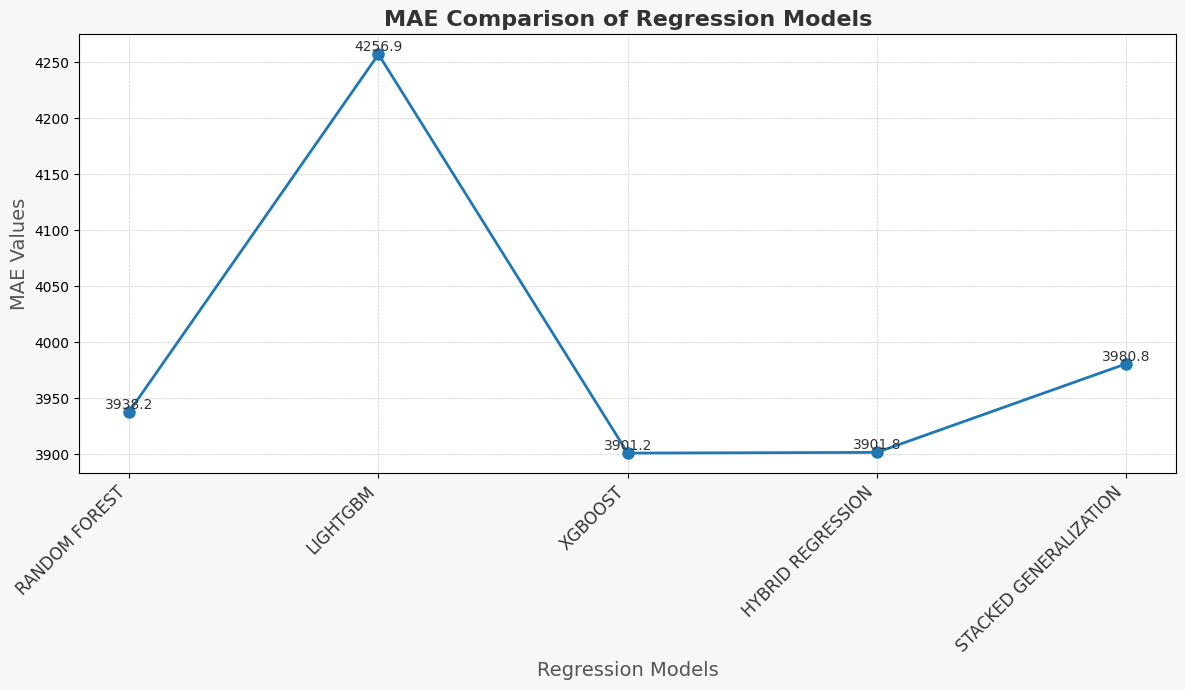

In [ ]:
# BIỂU ĐỒ SO SÁNH MAE

models = ['RANDOM FOREST', 'LIGHTGBM', 'XGBOOST', 'HYBRID REGRESSION', 'STACKED GENERALIZATION']
mae_values = [mae_2, mae_4, mae_6, mae_8, mae_10]  # Thay đổi biến ở đây cho MAE

plt.figure(figsize=(12, 7), facecolor='#f7f7f7')
plt.plot(models, mae_values, marker='o', linestyle='-', color='#1f77b4', markersize=8, linewidth=2)

# Thêm tiêu đề và nhãn
plt.title('MAE Comparison of Regression Models', fontsize=16, color='#333333', fontweight='bold')
plt.xlabel('Regression Models', fontsize=14, color='#555555')
plt.ylabel('MAE Values', fontsize=14, color='#555555')

# Lưới và các tùy chỉnh khác
plt.grid(color='#cccccc', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12, color='#333333')

# Thêm chú thích giá trị cho từng điểm với 5 chữ số thập phân
for i, value in enumerate(mae_values):
    plt.text(i, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10, color='#333333')

plt.tight_layout()
plt.show()

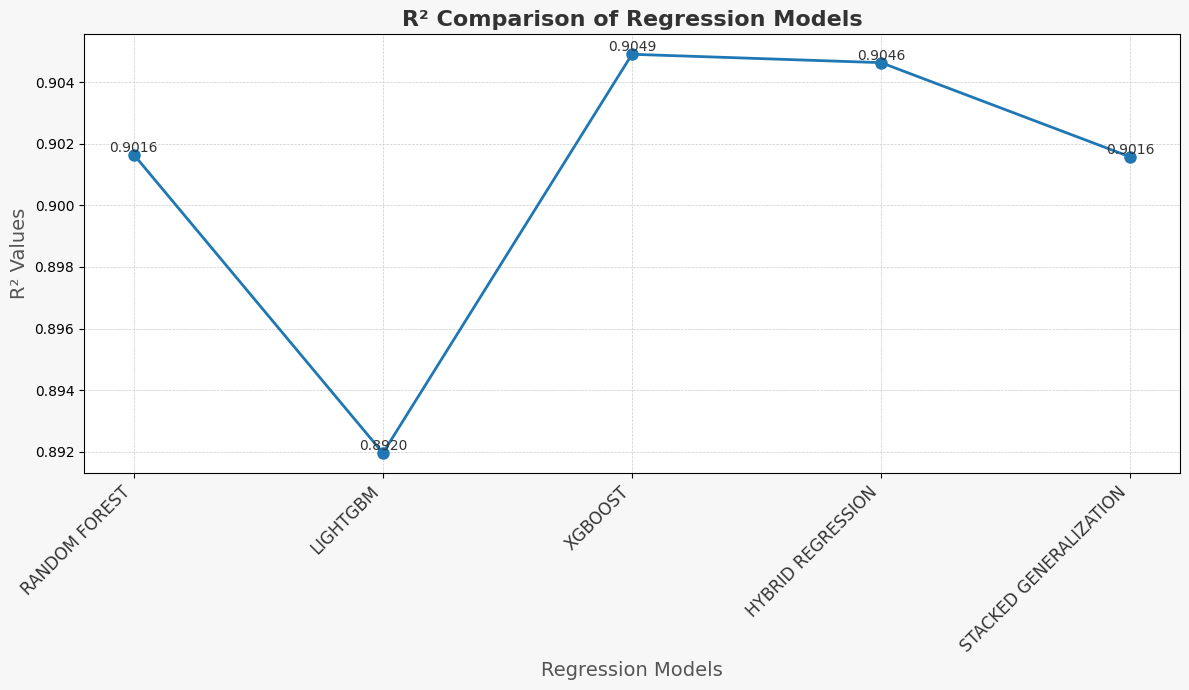

In [ ]:
# BIỂU ĐỒ SO SÁNH R²

models = ['RANDOM FOREST', 'LIGHTGBM', 'XGBOOST', 'HYBRID REGRESSION', 'STACKED GENERALIZATION']
r_squared_values = [r2_2, r2_4, r2_6, r2_8, r2_10]  # Thay đổi biến ở đây cho R²

plt.figure(figsize=(12, 7), facecolor='#f7f7f7')
plt.plot(models, r_squared_values, marker='o', linestyle='-', color='#1f77b4', markersize=8, linewidth=2)

# Thêm tiêu đề và nhãn
plt.title('R² Comparison of Regression Models', fontsize=16, color='#333333', fontweight='bold')
plt.xlabel('Regression Models', fontsize=14, color='#555555')
plt.ylabel('R² Values', fontsize=14, color='#555555')

# Lưới và các tùy chỉnh khác
plt.grid(color='#cccccc', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12, color='#333333')

# Thêm chú thích giá trị cho từng điểm
for i, value in enumerate(r_squared_values):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom', fontsize=10, color='#333333')

plt.tight_layout()
plt.show()

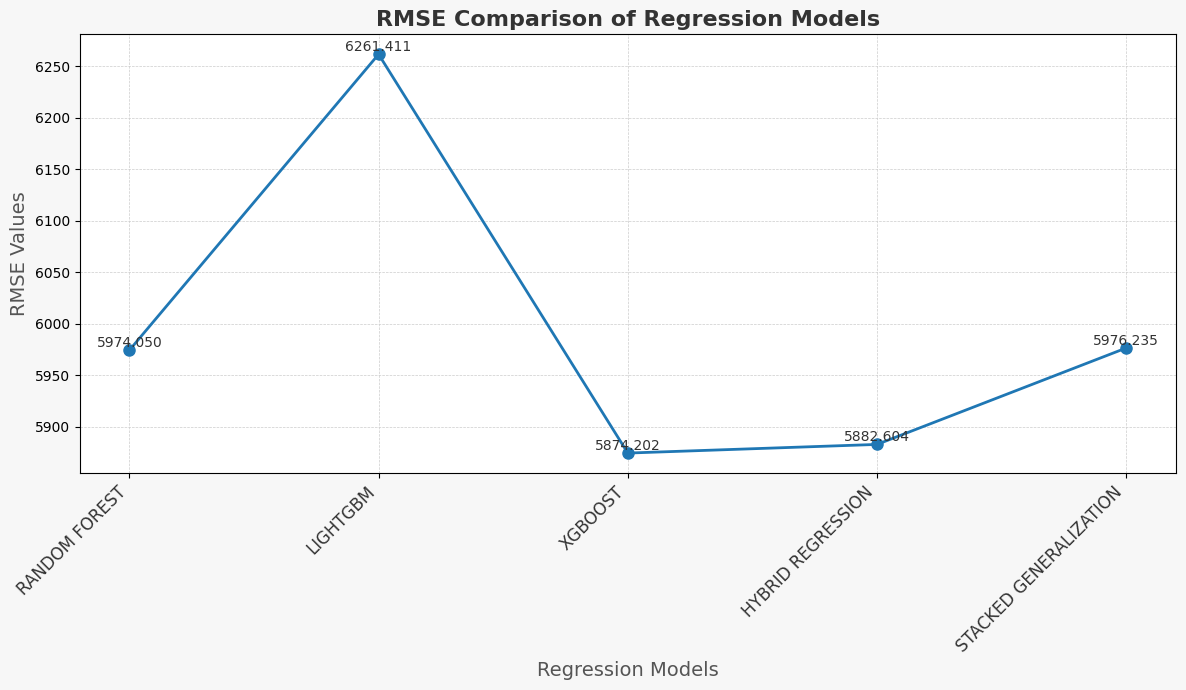

In [ ]:
# BIỂU ĐỒ SO SÁNH RMSE

models = ['RANDOM FOREST', 'LIGHTGBM', 'XGBOOST', 'HYBRID REGRESSION', 'STACKED GENERALIZATION']
rmse_values = [rmse_2, rmse_4, rmse_6, rmse_8, rmse_10]  # Thay đổi biến ở đây cho RMSE

plt.figure(figsize=(12, 7), facecolor='#f7f7f7')
plt.plot(models, rmse_values, marker='o', linestyle='-', color='#1f77b4', markersize=8, linewidth=2)

# Thêm tiêu đề và nhãn
plt.title('RMSE Comparison of Regression Models', fontsize=16, color='#333333', fontweight='bold')
plt.xlabel('Regression Models', fontsize=14, color='#555555')
plt.ylabel('RMSE Values', fontsize=14, color='#555555')

# Lưới và các tùy chỉnh khác
plt.grid(color='#cccccc', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12, color='#333333')

# Thêm chú thích giá trị cho từng điểm
for i, value in enumerate(rmse_values):
    plt.text(i, value, f'{value:.3f}', ha='center', va='bottom', fontsize=10, color='#333333')

plt.tight_layout()
plt.show()

# **THUẬT TOÁN MỚI**

# **BLENDING**

In [ ]:
# Huấn luyện các mô hình cơ sở
r1 = XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                   colsample_bytree=0.8, learning_rate=0.2, n_estimators=500,
                   reg_lambda=0.45, reg_alpha=0, gamma=0.5)
r2 = LGBMRegressor(objective='regression', num_leaves=36, learning_rate=0.15,
                    n_estimators=64, min_child_weight=2, colsample_bytree=0.8,
                    reg_lambda=0.45)
r3 = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20,
                           n_jobs=-1, min_samples_split=10)


# Huấn luyện các mô hình trên tập huấn luyện
r1.fit(train_X, train_y)
r2.fit(train_X, train_y)
r3.fit(train_X, train_y)


# Dự đoán trên tập kết hợp
pred_r1 = r1.predict(test_X)
pred_r2 = r2.predict(test_X)
pred_r3 = r3.predict(test_X)


# Tạo một DataFrame hoặc array để chứa các dự đoán
blend_predictions = np.vstack((pred_r1, pred_r2, pred_r3)).T


# Huấn luyện mô hình kết hợp (meta-learner)
meta_learner = LinearRegression()
meta_learner.fit(blend_predictions, test_y)


# Dự đoán trên tập test
# Dự đoán cho tập test bằng các mô hình cơ sở
test_predictions_r1 = r1.predict(X_test)
test_predictions_r2 = r2.predict(X_test)
test_predictions_r3 = r3.predict(X_test)


# Dự đoán trên tập test
blend_test_predictions = np.vstack((test_predictions_r1, test_predictions_r2, test_predictions_r3)).T


# Dự đoán cuối cùng bằng mô hình kết hợp
y_pred = meta_learner.predict(blend_test_predictions)


# Đánh giá mô hình bằng RMSLE
rmsle_blend = np.sqrt(mean_squared_log_error(y_test, y_pred))
mae_blend = mean_absolute_error(y_test, y_pred)
r2_blend = r2_score(y_test, y_pred)
rmse_blend = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"RMSLE của mô hình Blending: {rmsle_blend}")
print("MAE: {:,.5f}".format(mae_blend))
print("R²: {:,.5f}".format(r2_blend))
print("RMSE: {:,.5f}".format(rmse_blend))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 123339, number of used features: 19
[LightGBM] [Info] Start training from score 41028.655056
RMSLE của mô hình Blending: 0.3014699295403404
MAE: 3,873.41776
R²: 0.90550
RMSE: 5,855.97807


In [ ]:
# Hàm dự đoán giá trị 'price' dựa trên mô hình Blending
def predict_price_blending(lng, lat, trade_time, followers, square, living_room, building_type,
                           renovation_condition, building_structure, ladder_ratio, elevator,
                           five_years_property, subway, district, community_average, distance,
                           age, floor_type, floor_height):
    # Tạo DataFrame từ dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height]
    }
    input_df = pd.DataFrame(input_data)


    # Tiền xử lý dữ liệu (chuẩn hóa)
    input_scaled = scaler.transform(input_df)


    # Dự đoán với các mô hình cơ sở
    pred_r1 = r1.predict(input_scaled)
    pred_r2 = r2.predict(input_scaled)
    pred_r3 = r3.predict(input_scaled)


    # Tạo ma trận dự đoán từ các mô hình cơ sở
    blend_predictions = np.vstack((pred_r1, pred_r2, pred_r3)).T


    # Dự đoán với meta-learner
    predicted_price = meta_learner.predict(blend_predictions)
    print(f"Predicted Price: {predicted_price[0]:,.2f}")


# Tạo giao diện nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='Five Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')


button = widgets.Button(description="Dự đoán giá")


# Hàm xử lý khi nhấn nút "Predict Price"
def on_predict_button_clicked(b):
    predict_price_blending(
        lng.value, lat.value, trade_time.value, followers.value,
        square.value, living_room.value, building_type.value,
        renovation_condition.value, building_structure.value,
        ladder_ratio.value, elevator.value, five_years_property.value,
        subway.value, district.value, community_average.value,
        distance.value, age.value, floor_type.value, floor_height.value
    )


button.on_click(on_predict_button_clicked)


# Hiển thị giao diện
display(widgets.VBox([
    lng, lat, trade_time, followers, square, living_room, building_type,
    renovation_condition, building_structure, ladder_ratio, elevator,
    five_years_property, subway, district, community_average, distance,
    age, floor_type, floor_height, button
]))


# **STACKING REGRESSION**

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_log_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Định nghĩa hàm RMSLE
def rmsle_scorer(y_true, y_pred):

    # Đảm bảo y_pred không âm
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


# Định nghĩa tham số cho ElasticNet
elastic_net_param_grid = {
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}


# Sử dụng GridSearchCV để tìm kiếm tham số tốt nhất với RMSLE
elastic_net_grid_search = GridSearchCV(
    ElasticNet(random_state=42),
    elastic_net_param_grid,
    cv=kf,
    scoring=rmsle_scorer,  # Sử dụng hàm RMSLE
    return_train_score=True,
    n_jobs=-1
)


# Huấn luyện mô hình
elastic_net_grid_search.fit(X_train, y_train)


# Lấy mô hình tốt nhất
best_elastic_net_reg = elastic_net_grid_search.best_estimator_


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb


# Khởi tạo các mô hình cơ sở
rf = RandomForestRegressor(random_state=42, n_estimators=900, max_depth=20, n_jobs=-1, min_samples_split=10)
xg_reg = XGBRegressor(objective='reg:squarederror', min_child_weight=2, subsample=1,
                      colsample_bytree=0.8, learning_rate=0.2, n_estimators=500,
                      reg_lambda=0.45, reg_alpha=0, gamma=0.5)
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=36,
                        learning_rate=0.15,
                        n_estimators=64,
                        min_child_weight=2,
                        colsample_bytree=0.8,
                        reg_lambda=0.45)


# Base estimators
base_estimators = [
    ('elastic_net', best_elastic_net_reg),
    ('gbm',gbm),
    ('rf', rf),
    ('xgb', xg_reg)
]


# Tạo Stacking Regressor
stack_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], random_state=42),
    cv=5,  # Số lượng gập cho cross-validation
    passthrough=False,  # Có cho phép dữ liệu đầu vào được truyền qua không
    n_jobs=-1  # Sử dụng tất cả các CPU
)


# Huấn luyện Stacking Regressor
stack_reg.fit(X_train, y_train)
# Dự đoán trên tập test
y_pred = stack_reg.predict(X_test)


# ĐÁNH GIÁ MÔ HÌNH
rmsle_stacking = np.sqrt(mean_squared_log_error(y_test, y_pred))
mae_stacking = mean_absolute_error(y_test, y_pred)
r2_stacking = r2_score(y_test, y_pred)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred))


KeyboardInterrupt: 

In [ ]:
print(f"RMSLE của mô hình Stacking Regressor: {rmsle_stacking}")
print(f"MAE: {mae_stacking:.5f}")
print(f"R²: {r2_stacking:.5f}")
print(f"RMSE: {rmse_stacking:.5f}")

RMSLE của mô hình Stacking Regressor: 0.3010582231051035
MAE: 3835.84276
R²: 0.90685
RMSE: 5813.87993


In [ ]:
imp_df = pd.DataFrame({"Feature Name":x_train.columns,
                       "Importance":rfc.feature_importances_})

NameError: name 'pd' is not defined

In [ ]:
# Hàm dự đoán giá trị 'price' dựa trên mô hình Stacking
def predict_price_stacking(lng, lat, trade_time, followers, square, living_room, building_type,
                           renovation_condition, building_structure, ladder_ratio, elevator,
                           five_years_property, subway, district, community_average, distance,
                           age, floor_type, floor_height):
    # Tạo DataFrame từ dữ liệu đầu vào
    input_data = {
        'Lng': [lng],
        'Lat': [lat],
        'tradeTime': [trade_time],
        'followers': [followers],
        'square': [square],
        'livingRoom': [living_room],
        'buildingType': [building_type],
        'renovationCondition': [renovation_condition],
        'buildingStructure': [building_structure],
        'ladderRatio': [ladder_ratio],
        'elevator': [elevator],
        'fiveYearsProperty': [five_years_property],
        'subway': [subway],
        'district': [district],
        'communityAverage': [community_average],
        'distance': [distance],
        'Age': [age],
        'floorType': [floor_type],
        'floorHeight': [floor_height]
    }
    input_df = pd.DataFrame(input_data)


    # Tiền xử lý dữ liệu (chuẩn hóa)
    input_scaled = scaler.transform(input_df)


    # Dự đoán với mô hình Stacking Regressor
    predicted_price = stack_reg.predict(input_scaled)
    print(f"Predicted Price: {predicted_price[0]:,.2f}")




# Tạo giao diện nhập liệu
lng = widgets.FloatText(description='Lng:')
lat = widgets.FloatText(description='Lat:')
trade_time = widgets.FloatText(description='Trade Time:')
followers = widgets.FloatText(description='Followers:')
square = widgets.FloatText(description='Square:')
living_room = widgets.FloatText(description='Living Room:')
building_type = widgets.FloatText(description='Building Type:')
renovation_condition = widgets.FloatText(description='Renovation Condition:')
building_structure = widgets.FloatText(description='Building Structure:')
ladder_ratio = widgets.FloatText(description='Ladder Ratio:')
elevator = widgets.FloatText(description='Elevator:')
five_years_property = widgets.FloatText(description='Five Years Property:')
subway = widgets.FloatText(description='Subway:')
district = widgets.FloatText(description='District:')
community_average = widgets.FloatText(description='Community Average:')
distance = widgets.FloatText(description='Distance:')
age = widgets.FloatText(description='Age:')
floor_type = widgets.FloatText(description='Floor Type:')
floor_height = widgets.FloatText(description='Floor Height:')


button = widgets.Button(description="Dự đoán giá")


# Hàm xử lý khi nhấn nút "Predict Price"
def on_predict_button_clicked(b):
    predict_price_stacking(
        lng.value, lat.value, trade_time.value, followers.value,
        square.value, living_room.value, building_type.value,
        renovation_condition.value, building_structure.value,
        ladder_ratio.value, elevator.value, five_years_property.value,
        subway.value, district.value, community_average.value,
        distance.value, age.value, floor_type.value, floor_height.value
    )


button.on_click(on_predict_button_clicked)


# Hiển thị giao diện
display(widgets.VBox([
    lng, lat, trade_time, followers, square, living_room, building_type,
    renovation_condition, building_structure, ladder_ratio, elevator,
    five_years_property, subway, district, community_average, distance,
    age, floor_type, floor_height, button
]))
